In [1]:
# general tools
import sys

In [2]:
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import pickle
import pandas as pd
import netCDF4 as nc
import numpy as np

# stats tools
from skgstat import Variogram
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr, spearmanr

# graph tools
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [3]:
import importlib
importlib.reload(vu)

<module 'verif_utils' from '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/verif_utils.py'>

In [4]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Global settings

### Filepath & filename

In [5]:
DATA_dir = PRISM_dir
RESULT_dir = save_dir
era_feature_path = ERA_dir + 'ERA_TMEAN_features_2015_2020.hdf'
jra_feature_path = JRA_dir + 'JRA_TMEAN_features_2015_2020.hdf'
prism_path = PRISM_dir+'PRISM_regrid_2015_2020.hdf'
# result files
era_pred_name = 'ERA_TMEAN_clean'
jra_pred_name = 'JRA_TMEAN_clean'

In [6]:
TMEAN_key = 'TMEAN_025'
ERA_025_key = 'era_025'
ERA_raw_key = 'era_raw'
JRA_025_key = 'jra_025'
JRA_raw_key = 'jra_raw'

### Domain and time

In [7]:
with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    lon_025 = hdf_io['lon_025'][...]
    lat_025 = hdf_io['lat_025'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
#     etopo_025 = hdf_io['etopo_025'][...]
    land_mask = hdf_io['land_mask'][...]
    land_mask_clean = hdf_io['land_mask_025'][...]

In [8]:
ind_lat_US = [0, 100]
ind_lon_US = [60, 159]

### Time 

In [9]:
# available time range of the file (2018-2019) <----- support 2020 test in the furture 
N_all = 365 + 366 + 365 + 365 + 365
all_list = [datetime(2015, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# time range for plotting (2018-2019)
N_pred_era = 365 + 243
pred_list_era = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred_era)]
N_pred_jra = 365 + 365
pred_list_jra = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred_jra)]
# indices
ind_era = du.dt_match(all_list, pred_list_era)
ind_jra = du.dt_match(all_list, pred_list_jra)

In [10]:
fake_x = np.arange(N_pred_jra)

### Graph param.

In [11]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [12]:
cmap_mae = plt.cm.plasma_r # MAE colormap
cmap_line = plt.cm.plasma_r # line color "base"
camp_tmax_hist = plt.cm.plasma_r # TMAX histogram colormap
camp_tmin_hist = plt.cm.viridis_r # TMIN histogram colormap
camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

line_colors = [cmap_line(45), cmap_line(90), cmap_line(135), cmap_line(180), cmap_line(225)]

C1 = plt.cm.plasma(96)[:3]
C2 = plt.cm.plasma(225)[:3]
C3 = plt.cm.viridis(180)[:3]

In [13]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0.05, 
            'transparent':False}

## Import data

### 4km output

In [14]:
with h5py.File(save_dir+'JRA_PRED_TMEAN_2018_2020.hdf', 'r') as hdf_io:
    JRA_4km = hdf_io['RESULT_UNET'][...]
    
with h5py.File(save_dir+'ERA_PRED_TMEAN_2018_2020.hdf', 'r') as hdf_io:
    ERA_4km = hdf_io['RESULT_UNET'][...]

In [15]:
ERA_4km[:, land_mask] = np.nan
JRA_4km[:, land_mask] = np.nan

### Clean 0.25 degree

In [16]:
with h5py.File(ERA_dir+era_pred_name+'_2018.hdf', 'r') as hdf_io:
    ERA_2018 = hdf_io[TMEAN_key][...]
with h5py.File(ERA_dir+era_pred_name+'_2019.hdf', 'r') as hdf_io:
    ERA_2019 = hdf_io[TMEAN_key][...]
    
with h5py.File(JRA_dir+jra_pred_name+'_2018.hdf', 'r') as hdf_io:
    JRA_2018 = hdf_io[TMEAN_key][...]
with h5py.File(JRA_dir+jra_pred_name+'_2019.hdf', 'r') as hdf_io:
    JRA_2019 = hdf_io[TMEAN_key][...]
    
ERA_clean = np.concatenate((ERA_2018, ERA_2019), axis=0)
JRA_clean = np.concatenate((JRA_2018, JRA_2019), axis=0)

ERA_clean[:, land_mask_clean] = np.nan
JRA_clean[:, land_mask_clean] = np.nan

### Raw reanalysis

In [17]:
with h5py.File(era_feature_path, 'r') as hdf_io:
    ERA_raw = hdf_io[ERA_raw_key][ind_era, ...]
    lon_ERA = hdf_io['lon_raw'][...]
    lat_ERA = hdf_io['lat_raw'][...]

with h5py.File(jra_feature_path, 'r') as hdf_io:
    JRA_raw = hdf_io[JRA_raw_key][ind_jra, ...]
    lon_JRA = hdf_io['lon_raw'][...]
    lat_JRA = hdf_io['lat_raw'][...]

In [18]:
with h5py.File(save_dir+'CGAN_ERA_Variogram.hdf', 'r') as hdf_io:
    land_mask_ERA = hdf_io['land_mask'][...]
with h5py.File(save_dir+'CGAN_JRA_Variogram.hdf', 'r') as hdf_io:
    land_mask_JRA = hdf_io['land_mask'][...]

In [19]:
ERA_raw[:, land_mask_ERA] = np.nan
JRA_raw[:, land_mask_JRA] = np.nan

## Plot examples

In [53]:
edge = [-145, -101, 29, 58.25]
edge_US = [-125, -101, 29, 48]
edge_BC = [-140, -114, 48, 58.5]


In [21]:
def edge_inds(edge, lon, lat):
    indx, indy = du.grid_search(lon, lat, (edge[0], edge[1]), (edge[2], edge[3]))
    return [indx[0], indx[1], indy[0], indy[1]]

In [22]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes, zoomed_inset_axes, mark_inset, InsetPosition

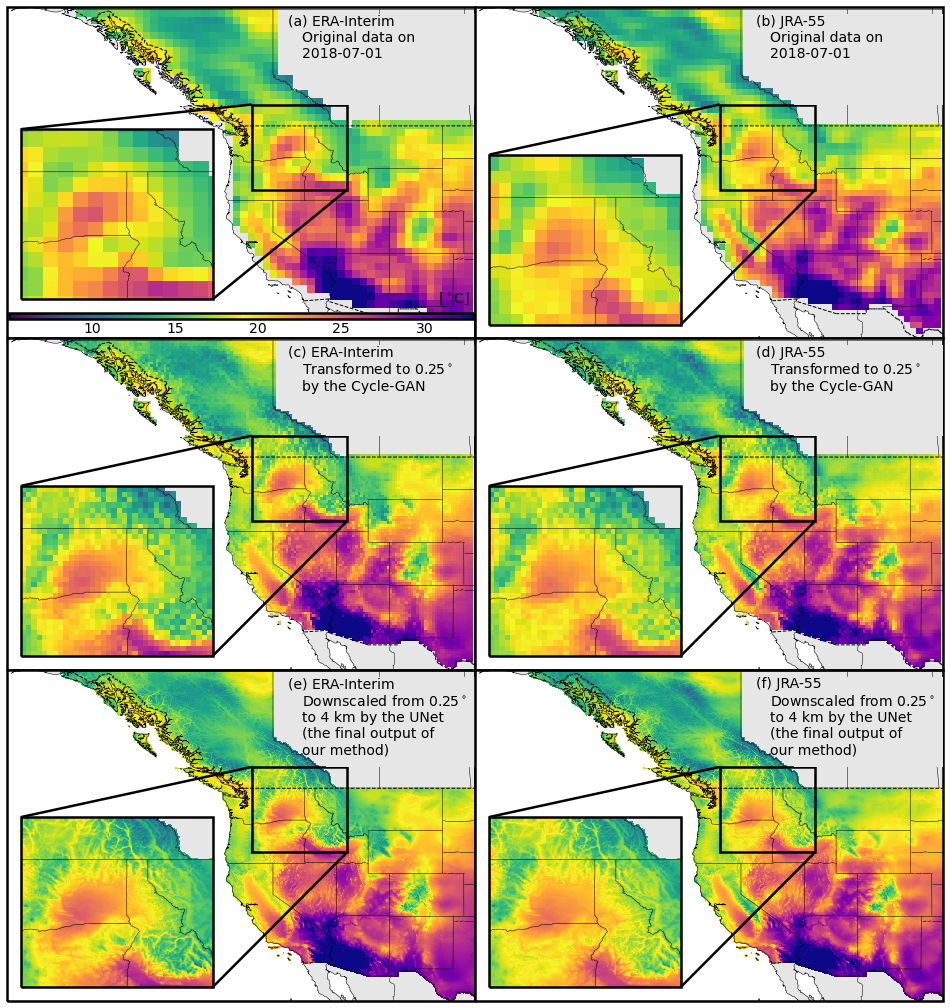

In [63]:
edge_sub=[-122, -113, 43, 51]

# ind_ERA = edge_inds(edge_sub, lon_ERA, lat_ERA)
# ind_JRA = edge_inds(edge_sub, lon_JRA, lat_JRA)
# ind_clean = edge_inds(edge_sub, lon_clean, lat_clean)
# ind_4km = edge_inds(edge_sub, lon_4km, lat_4km)

fig = plt.figure(figsize=(13, 13.8))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1])

ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax5 = plt.subplot(gs[2, 0], projection=ccrs.PlateCarree())
ax6 = plt.subplot(gs[2, 1], projection=ccrs.PlateCarree())
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

bbox_x = [0.45]*6
bbox_y = [0.647]+[0.57]*5
ax1_sub = zoomed_inset_axes(ax1, 2, bbox_to_anchor=(bbox_x[0], bbox_y[0]), bbox_transform=ax1.transAxes, 
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
ax2_sub = zoomed_inset_axes(ax2, 2, bbox_to_anchor=(bbox_x[1], bbox_y[1]), bbox_transform=ax2.transAxes, 
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
ax3_sub = zoomed_inset_axes(ax3, 2, bbox_to_anchor=(bbox_x[2], bbox_y[2]), bbox_transform=ax3.transAxes, 
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
ax4_sub = zoomed_inset_axes(ax4, 2, bbox_to_anchor=(bbox_x[3], bbox_y[3]), bbox_transform=ax4.transAxes, 
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
ax5_sub = zoomed_inset_axes(ax5, 2, bbox_to_anchor=(bbox_x[4], bbox_y[4]), bbox_transform=ax5.transAxes, 
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
ax6_sub = zoomed_inset_axes(ax6, 2, bbox_to_anchor=(bbox_x[5], bbox_y[5]), bbox_transform=ax6.transAxes, 
                            axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                            axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))

AX = [ax1, ax2, ax3, ax4, ax5, ax6]
AX_sub = [ax1_sub, ax2_sub, ax3_sub, ax4_sub, ax5_sub, ax6_sub]

titles = ['(a) ERA-Interim', 
          '(b) JRA-55', 
          '(c) ERA-Interim',
          '(d) JRA-55',
          '(e) ERA-Interim',
          '(f) JRA-55']

words = ['Original data on\n2018-07-01',
         'Original data on\n2018-07-01',
         'Transformed to 0.25$\mathsf{^\circ}$\nby the Cycle-GAN',
         'Transformed to 0.25$\mathsf{^\circ}$\nby the Cycle-GAN',
         'Downscaled from 0.25$\mathsf{^\circ}$\nto 4 km by the UNet\n(the final output of\nour method)',
         'Downscaled from 0.25$\mathsf{^\circ}$\nto 4 km by the UNet\n(the final output of\nour method)']

# ptitle_locx = [0.04, 0.04, 0.04, 0.04, 0.04, 0.04] 
# ptitle_locy = [0.285, 0.285, 0.285, 0.285, 0.285, 0.285] 

ptitle_locx = [0.6]*6
ptitle_locy = [0.9775]*6 
points = [[-115, 51], [-115, 59.5], [-100, 59.5], [-100, 51]]
    
for i, ax in enumerate(AX):
    ax.set_extent(edge, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.0)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
    ax.outline_patch.set_linewidth(2.5)
    # domain separation line
    handle_box = ax.text(ptitle_locx[i], ptitle_locy[i], titles[i], fontsize=14, ha='left', va='top', 
                         transform=ax.transAxes, zorder=4)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
    handle_box = ax.text(ptitle_locx[i]+0.03, ptitle_locy[i]-0.05, words[i], fontsize=14, ha='left', 
                         va='top', transform=ax.transAxes, zorder=4)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))
    

    boxes = PatchCollection([patches.Polygon(points)], facecolor='0.9', edgecolor='none', linewidth=0, zorder=3)
    ax.add_collection(boxes)
    
    # 
    mark_inset(ax, AX_sub[i], loc1=2, loc2=4, facecolor='none', edgecolor='k', linewidth=2.5)
    AX_sub[i].set_xlim([edge_sub[0], edge_sub[1]])
    AX_sub[i].set_ylim([edge_sub[2], edge_sub[3]])

handle_box = ax1.text(0.99, 0.095, '[$\mathsf{^\circ C}$]', fontsize=14, ha='right', va='bottom', transform=ax1.transAxes)
handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none')) 
    
for i, ax in enumerate(AX_sub):
    ax.set_extent(edge_sub, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=0.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
    ax.outline_patch.set_linewidth(2.5)

ind = 185
#tlim = [5.01, 32.99]
#tlim = [-25, 15]
tlim = [5.01, 32.99]
ax1.pcolormesh(lon_ERA, lat_ERA, ERA_raw[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax2.pcolormesh(lon_JRA, lat_JRA, JRA_raw[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax3.pcolormesh(lon_025, lat_025, ERA_clean[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax4.pcolormesh(lon_025, lat_025, JRA_clean[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax5.pcolormesh(lon_4km, lat_4km, ERA_4km[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
CS = ax6.pcolormesh(lon_4km, lat_4km, JRA_4km[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)

ax1_sub.pcolormesh(lon_ERA, lat_ERA, ERA_raw[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax2_sub.pcolormesh(lon_JRA, lat_JRA, JRA_raw[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax3_sub.pcolormesh(lon_025, lat_025, ERA_clean[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax4_sub.pcolormesh(lon_025, lat_025, JRA_clean[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax5_sub.pcolormesh(lon_4km, lat_4km, ERA_4km[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax6_sub.pcolormesh(lon_4km, lat_4km, JRA_4km[ind, ...], vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)

ax_base = fig.add_axes([0.002, 2/3+0.001, 1/2-0.003, 0.025]) #1/4+0.008, 0.0475
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.set_facecolor('w')
ax_base.set_alpha(0)
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='25%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.outline.set_linewidth(2.5)

# Save figure
fig.savefig(fig_dir+'CGAN_examples.png', format='png',  **fig_keys)

## OBS processing

In [23]:
with pd.HDFStore(OBS_dir+'obs_verif.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
stn_elev = metadata['elev'].values
stn_code = metadata['stn code'].values

In [24]:
with h5py.File(PRISM_dir+'PRISM_regrid_BC_clim.hdf', 'r') as h_io:
    land_mask_BC = h_io['land_mask'][...]
    lon_BC = h_io['lon_4km'][...]
    lat_BC = h_io['lat_4km'][...]
    
indx, indy = du.grid_search(lon_BC, lat_BC, stn_lon, stn_lat)
flag_pick = ~land_mask_BC[indx, indy]
flag_pick[indx==np.min(indx)]=False
flag_pick[indx==np.max(indx)]=False
flag_pick[indy==np.min(indy)]=False
flag_pick[indy==np.max(indy)]=False

In [25]:
stn_indx, stn_indy = du.grid_search(lon_4km, lat_4km, stn_lon, stn_lat)
etopo_stn = etopo_4km[stn_indx, stn_indy]
flag_good = np.abs(etopo_stn-stn_elev)/(5000-etopo_stn) < 0.01

In [26]:
flag_qc = np.logical_or(flag_pick, flag_good)

In [27]:
stn_lat = stn_lat[flag_qc]
stn_lon = stn_lon[flag_qc]
stn_elev = stn_elev[flag_qc]
stn_code = stn_code[flag_qc]

indx, indy = du.grid_search(lon_BC, lat_BC, stn_lon, stn_lat)
flag_pick = ~land_mask_BC[indx, indy]
flag_pick[indx==np.min(indx)]=False
flag_pick[indx==np.max(indx)]=False
flag_pick[indy==np.min(indy)]=False
flag_pick[indy==np.max(indy)]=False

flag_pick[stn_lat > 51] = True

In [28]:
N = 365 + 365
dt_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N)]
OBS = np.zeros([N, len(stn_code)])
with pd.HDFStore(OBS_dir+'obs_verif.hdf', 'r') as hdf_temp:
    for i, code in enumerate(stn_code):
        OBS[:, i] = hdf_temp[code]['value'].values
OBS = OBS*0.1 # units conversion

In [29]:
stn_indx, stn_indy = du.grid_search(lon_4km, lat_4km, stn_lon, stn_lat)
stn_indx2, stn_indy2 = du.grid_search(lon_025, lat_025, stn_lon, stn_lat)

# MPAS

In [80]:
with h5py.File(save_dir+'MPAS_single_test.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    lon_025 = hdf_io['lon_025'][...]
    lat_025 = hdf_io['lat_025'][...]
    lon_cell = hdf_io['lon_cell'][...]
    lat_cell = hdf_io['lat_cell'][...]
    TMEAN_MPAS = hdf_io['TMEAN_MPAS'][...]
    TMEAN_025 = hdf_io['TMEAN_025'][...]
    TMEAN_clean = hdf_io['TMEAN_clean'][...]
    TMEAN_4km = hdf_io['TMEAN_4km'][...]
    
TMEAN_025[land_mask_clean] = np.nan
TMEAN_clean[land_mask_clean] = np.nan
TMEAN_4km[land_mask] = np.nan

In [81]:
MPAS_raw = TMEAN_025[stn_indx2, stn_indy2]
MPAS_dscale = TMEAN_4km[stn_indx, stn_indy]

In [82]:
MAE_raw = du.mae_cal(OBS[-1, flag_pick], MPAS_raw[flag_pick])
MAE_dscale = du.mae_cal(OBS[-1, flag_pick], MPAS_dscale[flag_pick])

MAE_raw = np.round(MAE_raw, 3)
MAE_dscale = np.round(MAE_dscale, 3)
RMAE = np.round((MAE_raw-MAE_dscale)/MAE_raw*100, 2)

In [83]:
# name_list = ['United States of America']
# geom_US = gu.get_country_geom(name_list)# maskout us

In [84]:
from matplotlib import ticker

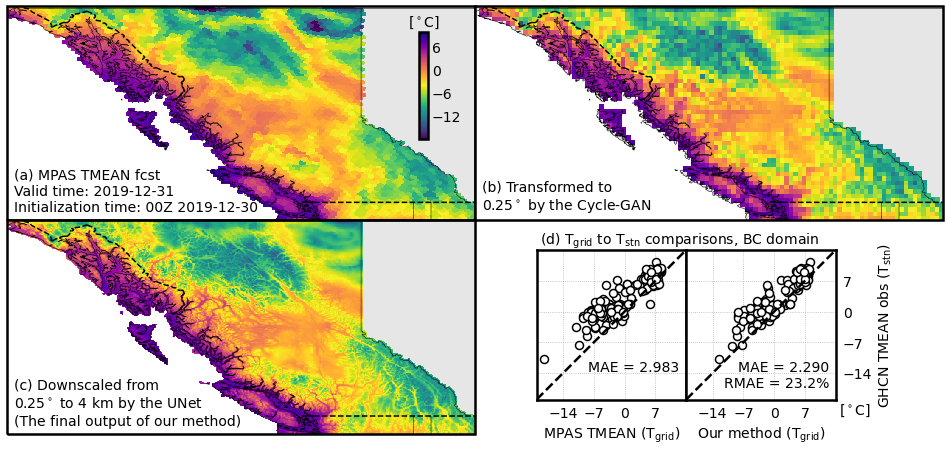

In [85]:
tlim = [-17.99, 9.99]

data_temp = np.load(MPAS_dir + 'geo.npy', allow_pickle=True)[()]
MPAS_mask = data_temp['MPAS_mask']
save_name = MPAS_dir+'mesh.pkl'
with open(save_name, 'rb') as pkl_io:
    mpas_poly = pickle.load(pkl_io)

TMEAN_MPAS[MPAS_mask] = np.nan

mpas_poly.set_array(TMEAN_MPAS)
mpas_poly.set_cmap(camp_t2)
mpas_poly.set_clim([tlim[0], tlim[1]])
mpas_poly.set_edgecolors('none')
mpas_poly.set_linewidth(0)
mpas_poly.set_transform(ccrs.Geodetic())
mpas_poly.set_antialiaseds(False)


edge = [-140, -100, 28, 59.75]
rate = 0.725
edge_US = [-1*(48-28)/rate-100, edge[1], edge[2], 48.6]
edge_BC = [edge[0], -141+(68.4-48.5)/rate, 48, edge[3]]

# ind_ERA = edge_inds(edge_sub, lon_ERA, lat_ERA)
# ind_JRA = edge_inds(edge_sub, lon_JRA, lat_JRA)
# ind_clean = edge_inds(edge_sub, lon_clean, lat_clean)
# ind_4km = edge_inds(edge_sub, lon_4km, lat_4km)

fig = plt.figure(figsize=(13, 5.935))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

R = 5.935/13

ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())

ax4 = fig.add_axes([0.52+0.1*R, 0.08, 0.35*R, 0.35], aspect='equal')
ax5 = fig.add_axes([0.52+0.35*R+0.1*R, 0.08, 0.35*R, 0.35], aspect='equal')
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

bbox_x = 0.385
bbox_y = 0.55

AX = [ax1, ax2, ax3]
AX_line = [ax4, ax5]

titles = ['(a) MPAS TMEAN fcst\nValid time: 2019-12-31\nInitialization time: 00Z 2019-12-30', 
          '(b) Transformed to\n0.25$\mathsf{^\circ}$ by the Cycle-GAN', 
          '(c) Downscaled from\n0.25$\mathsf{^\circ}$ to 4 km by the UNet\n(The final output of our method)']

# ptitle_locx = [0.04, 0.04, 0.04, 0.04, 0.04, 0.04] 
# ptitle_locy = [0.285, 0.285, 0.285, 0.285, 0.285, 0.285] 

ptitle_locx = [0.014, 0.014, 0.014]
ptitle_locy = [0.025, 0.025, 0.025]

for i, ax in enumerate(AX):
    ax.set_extent(edge_BC, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
    ax.outline_patch.set_linewidth(2.5)
    # domain separation line
    handle_box = ax.text(ptitle_locx[i], ptitle_locy[i], titles[i], fontsize=14, 
                         ha='left', va='bottom', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

for ax in AX_line:
    ax = gu.ax_decorate_box(ax)
    ax.grid(linestyle=':')
    ax.tick_params(labelbottom=True)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlim([-20, 14])
    ax.set_ylim([-20, 14])
    ax.set_xticks([-14, -7, 0, 7])
    ax.set_yticks([-14, -7, 0, 7])

ax4.set_xlabel('MPAS TMEAN ($\mathsf{T_{grid}}$)', fontsize=14)    
ax4.text(0.9075+0.1*R, 1.0, '(d) $\mathsf{T_{grid}}$ to $\mathsf{T_{stn}}$ comparisons, BC domain',
        ha='center', va='bottom', fontsize=14, transform=ax4.transAxes)

AX_line[1].text(1.02, -0.02, '[$\mathsf{^\circ C}$]',
        ha='left', va='top', fontsize=14, transform=AX_line[1].transAxes)

ax4.text(12.5, -18, 'MAE = {:.3f}\n'.format(MAE_raw), ha='right', va='bottom', fontsize=14)
ax5.text(12.5, -18, 'MAE = {:.3f}\nRMAE = {:.1f}%'.format(MAE_dscale, RMAE), ha='right', va='bottom', fontsize=14)

ax5.tick_params(labelright=True)
ax5.yaxis.set_label_position('right')
ax5.set_ylabel('GHCN TMEAN obs ($\mathsf{T_{stn}}$)', fontsize=14)
ax5.set_xlabel('Our method ($\mathsf{T_{grid}}$)', fontsize=14)

ax1.add_collection(mpas_poly)
CS = ax2.pcolormesh(lon_025, lat_025, TMEAN_clean, vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
ax3.pcolormesh(lon_4km, lat_4km, TMEAN_4km, vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)

iden_line = np.linspace(-20, 20, 100)
ax4.plot(MPAS_raw[flag_pick], OBS[-1, flag_pick], 'o', ms=8, mfc='w', mec='k', mew=1.5)
ax4.plot(iden_line, iden_line, 'k--', lw=2.5)
ax5.plot(MPAS_dscale[flag_pick], OBS[-1, flag_pick], 'o', ms=8, mfc='w', mec='k', mew=1.5)
ax5.plot(iden_line, iden_line, 'k--', lw=2.5)

ax_base = fig.add_axes([0.425, 0.69, 0.04, 0.25])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_facecolor('0.9')
cax = inset_axes(ax_base, height='100%', width='25%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='vertical', cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
tick_locator = ticker.MaxNLocator(nbins=5)
CBar.locator = tick_locator
CBar.update_ticks()
CBar.ax.set_title('[$\mathsf{^\circ C}$]', fontsize=14)
CBar.outline.set_linewidth(2.5)

# Save figure
fig.savefig(fig_dir+'CGAN_MPAS_example.png', format='png', **fig_keys)

# GFS

In [30]:
with h5py.File(save_dir+'CFSR_single_test.hdf', 'r') as hdf_io:
    lon_cfsr = hdf_io['lon_cfsr'][...]
    lat_cfsr = hdf_io['lat_cfsr'][...] 
    TMEAN_CFSR = hdf_io['TMEAN_CFSR'][...]
    TMEAN_clean_CFSR = hdf_io['TMEAN_clean'][...]
    TMEAN_4km_CFSR = hdf_io['TMEAN_4km'][...]

In [31]:
#lon_temp = lon_gfs - 360

In [32]:
# with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
#     land_mask_025 = hdf_io['land_mask_025'][...]
#     land_mask = hdf_io['land_mask'][...]
cfsr_mask = griddata((lon_025.ravel(), lat_025.ravel()), land_mask_clean.ravel(), (lon_cfsr, lat_cfsr), method='linear')
cfsr_mask = cfsr_mask > 0
#cfsr_mask[np.isnan(cfsr_mask)]=True
cfsr_mask[:, :10] = True
cfsr_mask[:, -4:] = True

In [33]:
TMEAN_CFSR[cfsr_mask] = np.nan
TMEAN_clean_CFSR[land_mask_clean] = np.nan
TMEAN_4km_CFSR[land_mask] = np.nan

In [34]:
stn_indx_cfsr, stn_indy_cfsr = du.grid_search(lon_cfsr, lat_cfsr, stn_lon, stn_lat)

In [35]:
flag_nonnan = ~np.isnan(OBS[-1, :])

In [36]:
stn_lon_plot_bc = stn_lon[flag_pick][flag_nonnan[flag_pick]]
stn_lat_plot_bc = stn_lat[flag_pick][flag_nonnan[flag_pick]]
stn_lon_plot_us = stn_lon[~flag_pick][flag_nonnan[~flag_pick]]
stn_lat_plot_us = stn_lat[~flag_pick][flag_nonnan[~flag_pick]]

In [37]:
OBS_CFSR = TMEAN_CFSR[stn_indx_cfsr, stn_indy_cfsr]
OBS_4km = TMEAN_4km_CFSR[stn_indx, stn_indy]

In [38]:
bad_flag_us_cold = np.logical_and(OBS_4km[~flag_pick] - OBS[-1, ~flag_pick] < -6, OBS_4km[~flag_pick] < -10)
bad_flag_us_warm = np.logical_and(OBS_4km[~flag_pick] - OBS[-1, ~flag_pick] < -5, OBS_4km[~flag_pick] > 7)

In [39]:
MAE_raw_BC = du.mae_cal(OBS[-1, flag_pick], OBS_CFSR[flag_pick])
MAE_dscale_BC = du.mae_cal(OBS[-1, flag_pick], OBS_4km[flag_pick])

MAE_raw_BC = np.round(MAE_raw_BC, 3)
MAE_dscale_BC = np.round(MAE_dscale_BC, 3)
RMAE_BC = np.round((MAE_raw_BC-MAE_dscale_BC)/MAE_raw_BC*100, 2)

In [40]:
MAE_raw_US = du.mae_cal(OBS[-1, ~flag_pick], OBS_CFSR[~flag_pick])
MAE_dscale_US = du.mae_cal(OBS[-1, ~flag_pick], OBS_4km[~flag_pick])

MAE_raw_US = np.round(MAE_raw_US, 3)
MAE_dscale_US = np.round(MAE_dscale_US, 3)
RMAE_US = np.round((MAE_raw_US-MAE_dscale_US)/MAE_raw_US*100, 2)

In [41]:
# def ATV(data, N):
#     grid_shape = data.shape
#     dTx = np.diff(data, axis=1)
#     dTy = np.diff(data, axis=0)
#     return (np.nansum(np.abs(dTx))+np.nansum(np.abs(dTy)))/N

# N_raw = np.sum(~cfsr_mask)
# N_clean = np.sum(~land_mask_clean)
# N_4km = np.sum(~land_mask)

# TV_raw = ATV(TMEAN_CFSR, 2*N_raw)
# TV_clean = ATV(TMEAN_clean_CFSR, 2*N_clean)
# TV_4km = ATV(TMEAN_4km_CFSR, 2*N_4km)

In [42]:
N_stn_bc = len(stn_lon_plot_bc)
N_stn_us = len(stn_lon_plot_us)

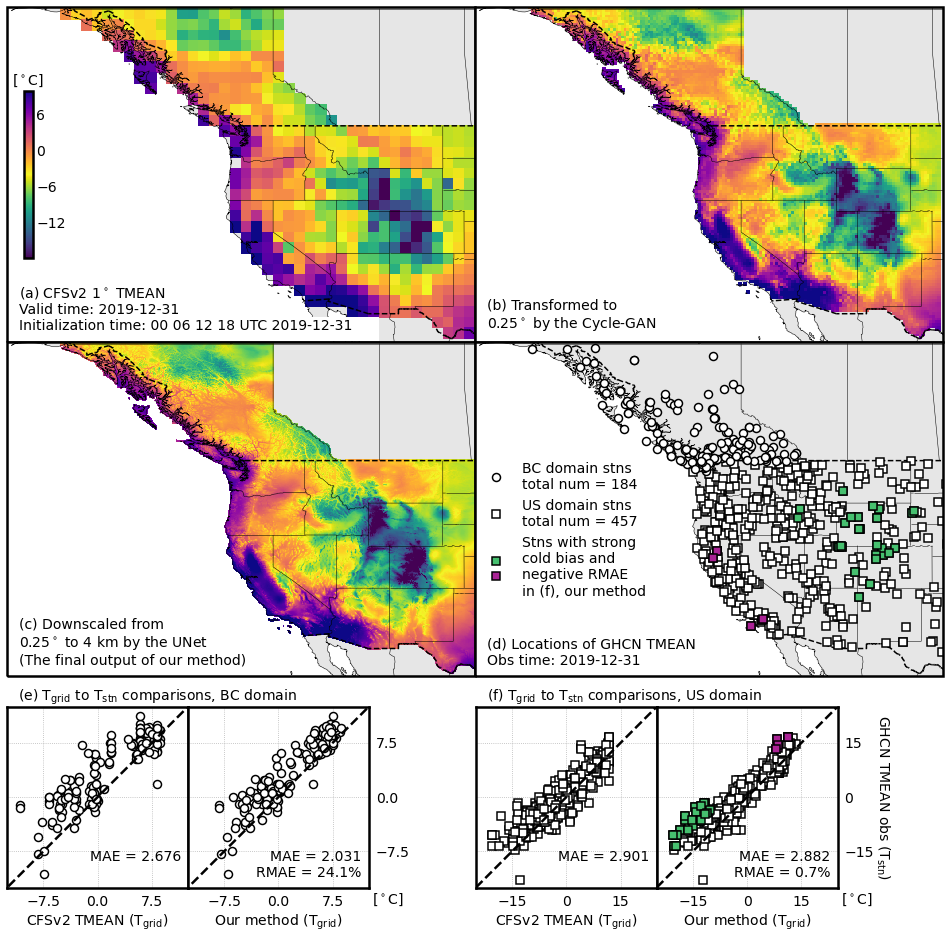

In [79]:
tlim = [-17.99, 9.99]

edge = [-145, -101, 28.7, 58.25]


# ind_ERA = edge_inds(edge_sub, lon_ERA, lat_ERA)
# ind_JRA = edge_inds(edge_sub, lon_JRA, lat_JRA)
# ind_clean = edge_inds(edge_sub, lon_clean, lat_clean)
# ind_4km = edge_inds(edge_sub, lon_4km, lat_4km)

fig = plt.figure(figsize=(13, 9.3))
gs = gridspec.GridSpec(2, 2)

R = 9.3/13
boxs = 0.27#0.2645
boxp = 0.08

ax1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())

#ax5 = fig.add_axes([1*boxp*R, 2*boxp+boxs, 2/3-2*boxp*R, boxs-2*boxp])

ax6 = fig.add_axes([0*boxp*R+0*boxs*R, 0-0.315, boxs*R, boxs])
ax7 = fig.add_axes([0*boxp*R+1*boxs*R, 0-0.315, boxs*R, boxs])
ax8 = fig.add_axes([2*boxp*R+2*boxs*R, 0-0.315, boxs*R, boxs])
ax9 = fig.add_axes([2*boxp*R+3*boxs*R, 0-0.315, boxs*R, boxs])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

bbox_x = 0.385
bbox_y = 0.55

AX = [ax1, ax2, ax3, ax4]
AX_line = [ax6, ax7, ax8, ax9]

titles = ['(a) CFSv2 1$\mathsf{^\circ}$ TMEAN\nValid time: 2019-12-31\nInitialization time: 00 06 12 18 UTC 2019-12-31', 
          '(b) Transformed to\n0.25$\mathsf{^\circ}$ by the Cycle-GAN', 
          '(c) Downscaled from\n0.25$\mathsf{^\circ}$ to 4 km by the UNet\n(The final output of our method)',
          '(d) Locations of GHCN TMEAN\nObs time: 2019-12-31']

# ptitle_locx = [0.04, 0.04, 0.04, 0.04, 0.04, 0.04] 
# ptitle_locy = [0.285, 0.285, 0.285, 0.285, 0.285, 0.285] 

ptitle_locx = [0.025, 0.025, 0.025, 0.025]
ptitle_locy = [0.025, 0.025, 0.025, 0.025] 

for i, ax in enumerate(AX):
    ax.set_extent(edge, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
    ax.outline_patch.set_linewidth(2.5)
    # domain separation line
    handle_box = ax.text(ptitle_locx[i], ptitle_locy[i], titles[i], fontsize=14, 
                         ha='left', va='bottom', transform=ax.transAxes, zorder=4)
    handle_box.set_bbox(dict(facecolor='none', alpha=1, edgecolor='none'))

points = [[-120, 28.8], [-120, 31], [-110, 31], [-110, 28.8]]
boxes = PatchCollection([patches.Polygon(points)], facecolor='w', edgecolor='none', linewidth=0, zorder=4)
AX[0].add_collection(boxes)

for i, ax in enumerate(AX_line):
    ax = gu.ax_decorate_box(ax)
    ax.grid(linestyle=':')
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    if i > 1:
        ax.set_xlim([-25, 25])
        ax.set_ylim([-25, 25])
        ax.set_xticks([-15, 0, 15])
        ax.set_yticks([-15, 0, 15])
    else:
        ax.set_xlim([-12.5, 12.5])
        ax.set_ylim([-12.5, 12.5])
        ax.set_xticks([-7.5, 0, 7.5])
        ax.set_yticks([-7.5, 0, 7.5])
    ax.tick_params(labelbottom=True)

AX_line[1].tick_params(labelright=True)
AX_line[3].tick_params(labelright=True)

AX_line[0].text(0.06, 1.0, '(e) $\mathsf{T_{grid}}$ to $\mathsf{T_{stn}}$ comparisons, BC domain',
        ha='left', va='bottom', fontsize=14, transform=AX_line[0].transAxes)
AX_line[2].text(0.06, 1.0, '(f) $\mathsf{T_{grid}}$ to $\mathsf{T_{stn}}$ comparisons, US domain',
        ha='left', va='bottom', fontsize=14, transform=AX_line[2].transAxes)

AX_line[0].text(11.5, -11.5, 'MAE = {:.3f}\n'.format(MAE_raw_BC), ha='right', va='bottom', fontsize=14)
AX_line[1].text(11.5, -11.5, 'MAE = {:.3f}\nRMAE = {:.1f}%'.format(MAE_dscale_BC, RMAE_BC), ha='right', va='bottom', fontsize=14)
AX_line[2].text(23, -23, 'MAE = {:.3f}\n'.format(MAE_raw_US), ha='right', va='bottom', fontsize=14)
AX_line[3].text(23, -23, 'MAE = {:.3f}\nRMAE = {:.1f}%'.format(MAE_dscale_US, RMAE_US), ha='right', va='bottom', fontsize=14)

AX_line[0].set_xlabel('CFSv2 TMEAN ($\mathsf{T_{grid}}$)', fontsize=14)
AX_line[1].set_xlabel('Our method ($\mathsf{T_{grid}}$)', fontsize=14)
AX_line[2].set_xlabel('CFSv2 TMEAN ($\mathsf{T_{grid}}$)', fontsize=14)
AX_line[3].set_xlabel('Our method ($\mathsf{T_{grid}}$)', fontsize=14)

AX_line[3].text(1.2, 0.5, 'GHCN TMEAN obs ($\mathsf{T_{stn}}$)',
        ha='left', va='center', rotation=270, fontsize=14, transform=AX_line[3].transAxes)
AX_line[3].text(1.02, -0.02, '[$\mathsf{^\circ C}$]',
        ha='left', va='top', fontsize=14, transform=AX_line[3].transAxes)
AX_line[1].text(1.02, -0.02, '[$\mathsf{^\circ C}$]',
        ha='left', va='top', fontsize=14, transform=AX_line[1].transAxes)

CS = AX[0].pcolormesh(lon_cfsr, lat_cfsr, TMEAN_CFSR, vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
AX[1].pcolormesh(lon_025, lat_025, TMEAN_clean_CFSR, vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)
AX[2].pcolormesh(lon_4km, lat_4km, TMEAN_4km_CFSR, vmin=tlim[0], vmax=tlim[1], cmap=camp_t2)

C = 'w'
handle_maker = []
handle_maker += AX[3].plot(stn_lon_plot_us, stn_lat_plot_us, 's', ms=8, mfc=C, mec='k', mew=1.5, 
                           label='US domain stns\ntotal num = {}'.format(N_stn_us))
handle_maker += AX[3].plot(stn_lon[~flag_pick][bad_flag_us_warm], stn_lat[~flag_pick][bad_flag_us_warm],
           's', ms=8, mfc=C1, mec='k', mew=1.5, label='Stns with strong\ncold bias and\nnegative RMAE\nin (f), our method\n')
AX[3].plot(stn_lon[~flag_pick][bad_flag_us_cold], stn_lat[~flag_pick][bad_flag_us_cold], 's', ms=8, mfc=C3, mec='k', mew=1.5)
handle_maker += AX[3].plot(stn_lon_plot_bc, stn_lat_plot_bc, 'o', ms=8, mfc=C, mec='k', mew=1.5, 
                           label='BC domain stns\ntotal num = {}'.format(N_stn_bc))

handle = [handle_maker[2], handle_maker[0], handle_maker[1]]

iden_line = np.linspace(-25, 25, 100)
AX_line[0].plot(OBS_CFSR[flag_pick], OBS[-1, flag_pick], 'o', ms=8, mfc=C, mec='k', mew=1.5)#C3
AX_line[0].plot(iden_line, iden_line, 'k--', lw=2.5)
AX_line[1].plot(OBS_4km[flag_pick], OBS[-1, flag_pick], 'o', ms=8, mfc=C, mec='k', mew=1.5)#C1
AX_line[1].plot(iden_line, iden_line, 'k--', lw=2.5)

AX_line[2].plot(OBS_CFSR[~flag_pick], OBS[-1, ~flag_pick], 's', ms=8, mfc=C, mec='k', mew=1.5)
AX_line[2].plot(iden_line, iden_line, 'k--', lw=2.5)
AX_line[3].plot(OBS_4km[~flag_pick], OBS[-1, ~flag_pick], 's', ms=8, mfc=C, mec='k', mew=1.5)
AX_line[3].plot(OBS_4km[~flag_pick][bad_flag_us_warm], OBS[-1, ~flag_pick][bad_flag_us_warm], 's', ms=8, mfc=C1, mec='k', mew=1.5)
AX_line[3].plot(OBS_4km[~flag_pick][bad_flag_us_cold], OBS[-1, ~flag_pick][bad_flag_us_cold], 's', ms=8, mfc=C3, mec='k', mew=1.5)
AX_line[3].plot(iden_line, iden_line, 'k--', lw=2.5)

ax_lg = fig.add_axes([0.5025, 0.12, 0.193, 0.22])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=handle, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax_in = inset_axes(AX[3], width='100%', height='100%', 
                   bbox_to_anchor=(0.03, 0.335, 0.05, 0.05), bbox_transform=AX[3].transAxes)
ax_in.plot(0, 0, 's', ms=8, mew=1.5, mec='k', mfc=C3)
ax_in.set_axis_off()

ax_base = fig.add_axes([0.0025, 0.625, 0.04, 0.25])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
ax_base.set_facecolor('none')
cax = inset_axes(ax_base, height='100%', width='25%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='vertical', cax=cax)
CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
tick_locator = ticker.MaxNLocator(nbins=5)
CBar.locator = tick_locator
CBar.update_ticks()
CBar.ax.set_title('[$\mathsf{^\circ C}$]', fontsize=14)
CBar.outline.set_linewidth(2.5)

# Save figure
fig.savefig(fig_dir+'CGAN_CFSR_example.png', format='png', **fig_keys)

In [336]:
12.5-25*rate_y

-17.225897920604915